<a href="https://colab.research.google.com/github/hayleypc/HawaiiClimate/blob/main/gen_soil_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from shapely.geometry import Point
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [145]:
def preprocess_data(matched_data):
    # Initial preprocessing
    matched_data['distance'] = 0
    matched_data = matched_data[matched_data["depth_adj_bottom"] == '20']
    matched_data['imp_c_float'] = [float(datum) for datum in matched_data['imp_c']]

    # Select ID fields that are non-numeric since can't run minmax scalar over non numeric
    id_fields = matched_data[['source_dataset', 'island','dist_id', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude','x_sample','y_sample','x_driver','y_driver']]

    # Select numeric columns and preprocess
    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                 'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                 'agbd_m', 'agbd_sd', 'agbd_n']
    numeric_cols = matched_data[keep_cols]
    numeric_cols.replace('', np.nan, inplace=True)
    numeric_cols = numeric_cols.astype(float)
    numeric_cols.fillna(0, inplace=True)

    # Scale numeric columns
    scaler = MinMaxScaler()
    scaler.fit(numeric_cols)
    scaled_numeric_cols = scaler.transform(numeric_cols)
    scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

    #min max scale imp_c, keep scalers
    min_c = np.min(matched_data['imp_c_float'])
    max_c = np.max(matched_data['imp_c_float'])
    scaled_imp_c = (matched_data['imp_c_float'] - min_c) / (max_c - min_c)

    # Combine ID fields with scaled numeric data
    numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

    numeric_df['imp_c_scaled'] = scaled_imp_c

    return numeric_df, scaler, min_c, max_c

In [7]:
def train_model_a(preprocess_data):

    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    X = preprocess_data[keep_cols]

    y = preprocess_data['imp_c_scaled']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define model
    def build_model(input_shape):
        model = Sequential([
            Dense(256, activation='relu', input_dim=input_shape),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(512, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1024, activation='relu'),
            BatchNormalization(),
            LeakyReLU(alpha=0.2),
            Dropout(0.3),
            Dense(1, activation='linear')
        ])
        return model

    model = build_model(X_train.shape[1])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test).flatten()
    r_squared = r2_score(y_test, predictions)

    return model, test_loss, r_squared, predictions, y_test

In [8]:
# imputed SOC dostributions
file_path = '/content/drive/MyDrive/hawaii_soils/HI soils data/annotated_combo_imputed_SOC.gpkg'

gdf = gpd.read_file(file_path)

In [9]:
def predict_on_reserve(preprocess_data, model, min_c, max_c):

    df_out = preprocess_data.copy()
    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    X = preprocess_data[keep_cols]
    y = preprocess_data['imp_c_scaled']

    # Predictions and Evaluation
    predictions = model.predict(X)

    inversed_predictions =  predictions*max_c+min_c

    inversed_truth =  y*max_c+min_c

    df_out['predictions'] = predictions
    df_out['inversed_predictions'] = inversed_predictions
    df_out['inversed_imp_c'] = inversed_truth

    return df_out

In [10]:
def evaluate_model(model, X_test, y_test, scaler, inversed_predictions, inversed_truth):
    test_loss = model.evaluate(X_test, y_test)
    r_squared = r2_score(inversed_truth, inversed_predictions)

    print("Test Loss:", test_loss)
    print("R-Squared Score:", r_squared)

    mae = mean_absolute_error(inversed_truth, inversed_predictions)
    rmse = mean_squared_error(inversed_truth, inversed_predictions, squared=False)

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)

    # Scatter plot of true vs predicted values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=inversed_truth, y=inversed_predictions)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.plot([min(inversed_truth), max(inversed_truth)], [min(inversed_truth), max(inversed_truth)], 'r')  # Diagonal line
    plt.show()

    # Residual plot
    residuals = inversed_truth - inversed_predictions
    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.xlabel("Residuals")
    plt.title("Distribution of Residuals")
    plt.show()

# model, test_loss, r_squared, inversed_predictions, inversed_truth, scaler, X_test, y_test = preprocess_and_train_model(matched_data)
# evaluate_model(model, X_test, y_test, scaler, inversed_predictions, inversed_truth)

In [11]:
file_path = '/content/drive/My Drive/sequence_data.csv'

In [155]:
drivers_gpd = gpd.read_file('/content/drive/MyDrive/hawaii_soils/Analysis Data/250_summary_grid_dt.gpkg')

In [156]:
soils_csv = gpd.read_file('/content/drive/MyDrive/hawaii_soils/HI soils data/combined_soc_2024_04_05.csv')

In [157]:
# Filter the DataFrame using .loc
soils_csv = soils_csv.loc[(soils_csv['latitude'] != '') & (soils_csv['longitude'] != '')]

# Create geometry column
soils_csv['geometry'] = soils_csv.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)

# Convert to GeoDataFrame
soils_gpd = gpd.GeoDataFrame(soils_csv, geometry='geometry', crs="EPSG:4326")


In [158]:
soils_gpd = pd.merge(soils_gpd, gdf.loc[:,['dist_id','unique_id']], on='unique_id', how='inner')

In [159]:
# Ensure both GeoDataFrames have the same CRS
soils_gpd = soils_gpd.to_crs(drivers_gpd.crs)

# Perform spatial join
matched_data = gpd.sjoin_nearest(soils_gpd, drivers_gpd, how='left', distance_col='distance')

In [160]:
drivers_gpd['x_driver'] = drivers_gpd.geometry.x
drivers_gpd['y_driver'] = drivers_gpd.geometry.y

In [161]:
# Apply a buffer to each geometry in one of the GeoDataFrames (e.g., soils_gpd)
soils_buffered = soils_gpd.copy().to_crs('ESRI:102261')
soils_buffered['x_sample'] = soils_buffered.geometry.x
soils_buffered['y_sample'] = soils_buffered.geometry.y

soils_buffered.geometry = soils_buffered.to_crs(epsg=32604).geometry.buffer(1000)

# soils_gpd = soils_gpd
# Step 2: Spatial Join
# Perform a spatial join with the buffered GeoDataFrame
# This finds all drivers_gpd points that fall within the 10,000-meter buffer of any point in soils_gpd
matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', predicate='intersects')


<ipython-input-161-c94194ce54c9>:12: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:32604
Right CRS: ESRI:102261

  matches_within_distance = gpd.sjoin(soils_buffered, drivers_gpd, how='left', predicate='intersects')


In [162]:
matches_within_distance.columns

Index(['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top',
       'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude', 'c_perc',
       'imp_c', 'bulk_density', 'imp_bd', 'hole_id', 'geometry', 'dist_id',
       'x_sample', 'y_sample', 'index_right', 'id', 'left', 'top', 'right',
       'bottom', 'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'max', 'elevation',
       'landform', 'SRTM_mTPI', 'aet', 'def', 'pdsi', 'pet', 'pr', 'ro',
       'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m',
       'agbd_sd', 'agbd_n', 'majorcomposition', 'age_years', 'age_class',
       'x_driver', 'y_driver'],
      dtype='object')

In [163]:
numeric_df, scaler, min_c, max_c = preprocess_data(matches_within_distance)

/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
<ipython-input-145-b0e32b0fb93a>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [164]:
numeric_df.columns

Index(['source_dataset', 'island', 'dist_id', 'soil_column_id', 'unique_id',
       'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude',
       'longitude', 'x_sample', 'y_sample', 'x_driver', 'y_driver', 'water',
       'trees', 'grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub',
       'built', 'bare', 'snow_and_ice', 'max', 'elevation', 'landform',
       'SRTM_mTPI', 'aet', 'def', 'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad',
       'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m', 'agbd_sd',
       'agbd_n', 'imp_c_scaled'],
      dtype='object')

In [20]:
frequency_table = numeric_df['unique_id'].value_counts().reset_index()
frequency_table.columns = ['unique_id', 'count']
frequency_table['count'].unique()

array([52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 38, 37, 36, 35,
       34, 33, 32, 31, 30, 29, 28, 27, 26, 22,  3,  1])

In [21]:
# selecting one random distribution id to leave out for cross validation
xval_id = np.random.choice(numeric_df['dist_id'].unique())

In [125]:
# numeric_df.columns

Index(['source_dataset', 'island', 'dist_id', 'soil_column_id', 'unique_id',
       'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude',
       'longitude', 'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'max', 'elevation',
       'landform', 'SRTM_mTPI', 'aet', 'def', 'pdsi', 'pet', 'pr', 'ro',
       'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m',
       'agbd_sd', 'agbd_n', 'imp_c_scaled'],
      dtype='object')

In [52]:
numeric_df['dist_id'].isna().sum()

101657

In [66]:
# # Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')
    ])
    return model

In [178]:
    real_rf_ready = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  [imp_c_quantiles]]

    # Use the trained model to make predictions
    real_labels_encoded = rf_model.predict(real_rf_ready)


    # Decode the encoded labels back to original labels
    real_predicted_labels = label_encoder.inverse_transform(real_labels_encoded)
    real_predicted_labels

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array(['uniform'], dtype=object)

In [179]:
# Cross-validation: need to loop through all dist_ids, one at a time
# subset data to exclude unlabeled distributions 1st

data = numeric_df.dropna(subset=['dist_id'])

unique_dist_ids = data['dist_id'].unique()
np.random.shuffle(unique_dist_ids)


result_list = []

# Loop over each dist_id, leaving one out at time
for xval_id in unique_dist_ids[[1,2,3,4,5]]:
    r2_list = []
    loss_list = []
    prediction_list = []
    matched_data_list = []
    model_list = []
    # Reserve data for validation
    xval_data = data[data['dist_id'] == xval_id]

    # Matched data for training
    train_data = data[data['dist_id'] != xval_id]

    reserve_data = train_data.groupby('unique_id').sample(n=1)

    for i in range(10):
        matched_data = train_data.groupby('unique_id').sample(n=1)
        matched_data = matched_data.reset_index(drop=True)

        model, test_loss, r_squared, predictions, y_test = train_model_a(matched_data)

        predictions = predict_on_reserve(reserve_data, model, min_c, max_c)

        matched_data_list.append(matched_data)
        prediction_list.append(predictions)
        model_list.append(model)
        loss_list.append(test_loss)
        r2_list.append(r_squared)

    combined_array = np.array([predictions['predictions'].values for predictions in prediction_list])
    combined_array[combined_array < 0 ] = 0

    arr_min = np.min(combined_array.flatten())
    arr_max = np.max(combined_array.flatten())

    dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
    norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

    keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
                'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
                'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
                'agbd_m', 'agbd_sd', 'agbd_n']

    scaled_numeric_df = prediction_list[0][keep_cols]
    # numeric_cols = predictions.iloc[:,keep_cols]

    scaled_numeric_df['norm_dist_array'] = norm_dist_array



    scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()
    scaled_numeric_df.dropna(inplace=True)

    norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

    X = scaled_numeric_df.iloc[:, :-1]
    y = scaled_numeric_df.iloc[:, -1]

    x = np.array(X)
    y = np.array(norm_dist_array)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # print(X_train.shape[1])
    model = build_model(X_train.shape[1],output_shape=10)

    # model = build_model((X_train.shape[1]))
    # model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
    # model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
    model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

    test_loss = model.evaluate(X_test, y_test)


    predictions = model.predict(xval_data[keep_cols])
    imp_c_scaled = np.sort(xval_data.groupby('unique_id').sample(n=1)['imp_c_scaled']*max_c+min_c)

    imp_c_quantiles = np.quantile(imp_c_scaled, np.linspace(0, 1,10))

    scaled_predictions = predictions*max_c+min_c
    prediction_quantiles = [np.quantile(prediction, np.linspace(0, 1,10)) for prediction in scaled_predictions]

    prediction_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  predictions]

    # Use the trained model to make predictions
    predicted_labels_encoded = rf_model.predict(prediction_rf_ready_predictions)

    # Decode the encoded labels back to original labels
    predicted_predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

    real_rf_ready = [rescale_to_minus_one_one(sorted(prediction)+ np.random.uniform(-0.001, 0.001, prediction.shape[0])) for prediction in  [imp_c_quantiles]]

    # Use the trained model to make predictions
    real_labels_encoded = rf_model.predict(real_rf_ready)


    # Decode the encoded labels back to original labels
    real_predicted_labels = label_encoder.inverse_transform(real_labels_encoded)

    lat_lon = [Point(xy) for xy in zip(xval_data['latitude'],xval_data['longitude'])]
    xy_sample = [Point(xy) for xy in zip(xval_data['x_sample'],xval_data['y_sample'])]
    xy_driver = [Point(xy) for xy in zip(xval_data['x_driver'],xval_data['y_driver'])]

    result_dict ={
                  "xval_id": xval_id,
                  "lat_lon": lat_lon,
                  "xy_sample": xy_sample,
                  "xy_driver": xy_driver,
                  "imp_c_scaled": imp_c_scaled,
                  "imp_c_quantiles": imp_c_quantiles,
                  "real_predicted_labels": real_predicted_labels,
                  "scaled_predictions": scaled_predictions,
                  "prediction_quantiles": prediction_quantiles,
                  "predicted_predicted_labels": predicted_predicted_labels
                }
    result_list.append(result_dict)

Epoch 1/100
3/3 [==============================] - 2s 100ms/step - loss: 0.0061 - val_loss: 0.0026
Epoch 2/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 4/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 6/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0025
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 9/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 10/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0048 - val_loss: 0.0022
Epoch 11/100
3/3 [

<ipython-input-179-c799c36db537>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-179-c799c36db537>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()
<ipython-input-179-c799c36db537>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

3/3 [==============================] - 2s 107ms/step - loss: 0.3654 - mae: 0.5290 - val_loss: 0.3637 - val_mae: 0.5277
Epoch 2/600
3/3 [==============================] - 0s 18ms/step - loss: 0.3628 - mae: 0.5270 - val_loss: 0.3609 - val_mae: 0.5256
Epoch 3/600
3/3 [==============================] - 0s 17ms/step - loss: 0.3599 - mae: 0.5249 - val_loss: 0.3579 - val_mae: 0.5234
Epoch 4/600
3/3 [==============================] - 0s 18ms/step - loss: 0.3569 - mae: 0.5227 - val_loss: 0.3548 - val_mae: 0.5211
Epoch 5/600
3/3 [==============================] - 0s 18ms/step - loss: 0.3538 - mae: 0.5204 - val_loss: 0.3516 - val_mae: 0.5186
Epoch 6/600
3/3 [==============================] - 0s 19ms/step - loss: 0.3505 - mae: 0.5179 - val_loss: 0.3482 - val_mae: 0.5161
Epoch 7/600
3/3 [==============================] - 0s 18ms/step - loss: 0.3471 - mae: 0.5153 - val_loss: 0.3447 - val_mae: 0.5134
Epoch 8/600
3/3 [==============================] - 0s 17ms/step - loss: 0.3435 - mae: 0.5126 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Epoch 1/100
3/3 [==============================] - 2s 101ms/step - loss: 0.0077 - val_loss: 0.0037
Epoch 2/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0066 - val_loss: 0.0041
Epoch 3/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0065 - val_loss: 0.0035
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 5/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 6/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0063 - val_loss: 0.0036
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0063 - val_loss: 0.0037
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0064 - val_loss: 0.0035
Epoch 9/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0063 - val_loss: 0.0035
Epoch 11/100
3/3 [

<ipython-input-179-c799c36db537>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-179-c799c36db537>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()
<ipython-input-179-c799c36db537>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

3/3 [==============================] - 2s 106ms/step - loss: 0.4217 - mae: 0.5724 - val_loss: 0.4198 - val_mae: 0.5711
Epoch 2/600
3/3 [==============================] - 0s 17ms/step - loss: 0.4188 - mae: 0.5704 - val_loss: 0.4168 - val_mae: 0.5690
Epoch 3/600
3/3 [==============================] - 0s 18ms/step - loss: 0.4157 - mae: 0.5683 - val_loss: 0.4136 - val_mae: 0.5667
Epoch 4/600
3/3 [==============================] - 0s 17ms/step - loss: 0.4125 - mae: 0.5660 - val_loss: 0.4102 - val_mae: 0.5643
Epoch 5/600
3/3 [==============================] - 0s 17ms/step - loss: 0.4091 - mae: 0.5636 - val_loss: 0.4067 - val_mae: 0.5618
Epoch 6/600
3/3 [==============================] - 0s 17ms/step - loss: 0.4055 - mae: 0.5610 - val_loss: 0.4031 - val_mae: 0.5592
Epoch 7/600
3/3 [==============================] - 0s 18ms/step - loss: 0.4018 - mae: 0.5583 - val_loss: 0.3992 - val_mae: 0.5564
Epoch 8/600
3/3 [==============================] - 0s 16ms/step - loss: 0.3980 - mae: 0.5555 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Epoch 1/100
3/3 [==============================] - 2s 100ms/step - loss: 0.0085 - val_loss: 0.0039
Epoch 2/100
3/3 [==============================] - 0s 18ms/step - loss: 0.0070 - val_loss: 0.0047
Epoch 3/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 4/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 5/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0037
Epoch 6/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0068 - val_loss: 0.0039
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0068 - val_loss: 0.0040
Epoch 8/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 9/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0068 - val_loss: 0.0037
Epoch 10/100
3/3 [==============================] - 0s 17ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 11/100
3/3 [

<ipython-input-179-c799c36db537>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-179-c799c36db537>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()
<ipython-input-179-c799c36db537>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

3/3 [==============================] - 2s 110ms/step - loss: 0.2154 - mae: 0.3364 - val_loss: 0.2140 - val_mae: 0.3353
Epoch 2/600
3/3 [==============================] - 0s 18ms/step - loss: 0.2134 - mae: 0.3347 - val_loss: 0.2120 - val_mae: 0.3335
Epoch 3/600
3/3 [==============================] - 0s 19ms/step - loss: 0.2112 - mae: 0.3329 - val_loss: 0.2098 - val_mae: 0.3316
Epoch 4/600
3/3 [==============================] - 0s 18ms/step - loss: 0.2090 - mae: 0.3310 - val_loss: 0.2075 - val_mae: 0.3296
Epoch 5/600
3/3 [==============================] - 0s 18ms/step - loss: 0.2067 - mae: 0.3290 - val_loss: 0.2051 - val_mae: 0.3275
Epoch 6/600
3/3 [==============================] - 0s 17ms/step - loss: 0.2043 - mae: 0.3268 - val_loss: 0.2027 - val_mae: 0.3252
Epoch 7/600
3/3 [==============================] - 0s 18ms/step - loss: 0.2018 - mae: 0.3245 - val_loss: 0.2002 - val_mae: 0.3228
Epoch 8/600
3/3 [==============================] - 0s 18ms/step - loss: 0.1993 - mae: 0.3221 - val_lo

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Epoch 1/100
4/4 [==============================] - 2s 71ms/step - loss: 0.0074 - val_loss: 0.0049
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0060 - val_loss: 0.0048
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0063 - val_loss: 0.0045
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0059 - val_loss: 0.0053
Epoch 6/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0067 - val_loss: 0.0059
Epoch 7/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0068 - val_loss: 0.0048
Epoch 8/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 9/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0058 - val_loss: 0.0045
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 11/100
4/4 [=

<ipython-input-179-c799c36db537>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-179-c799c36db537>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()
<ipython-input-179-c799c36db537>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

4/4 [==============================] - 3s 88ms/step - loss: 0.2884 - mae: 0.4165 - val_loss: 0.2860 - val_mae: 0.4147
Epoch 2/600
4/4 [==============================] - 0s 16ms/step - loss: 0.2852 - mae: 0.4141 - val_loss: 0.2826 - val_mae: 0.4121
Epoch 3/600
4/4 [==============================] - 0s 15ms/step - loss: 0.2817 - mae: 0.4115 - val_loss: 0.2790 - val_mae: 0.4093
Epoch 4/600
4/4 [==============================] - 0s 14ms/step - loss: 0.2781 - mae: 0.4087 - val_loss: 0.2752 - val_mae: 0.4063
Epoch 5/600
4/4 [==============================] - 0s 14ms/step - loss: 0.2742 - mae: 0.4056 - val_loss: 0.2712 - val_mae: 0.4031
Epoch 6/600
4/4 [==============================] - 0s 14ms/step - loss: 0.2702 - mae: 0.4023 - val_loss: 0.2671 - val_mae: 0.3996
Epoch 7/600
4/4 [==============================] - 0s 14ms/step - loss: 0.2659 - mae: 0.3988 - val_loss: 0.2627 - val_mae: 0.3959
Epoch 8/600
4/4 [==============================] - 0s 15ms/step - loss: 0.2616 - mae: 0.3951 - val_los

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Epoch 1/100
4/4 [==============================] - 3s 76ms/step - loss: 0.0074 - val_loss: 0.0059
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0048
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0045
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0067 - val_loss: 0.0052
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0061 - val_loss: 0.0046
Epoch 10/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 11/100
4/4 [=

<ipython-input-179-c799c36db537>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array
<ipython-input-179-c799c36db537>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()
<ipython-input-179-c799c36db537>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

4/4 [==============================] - 2s 80ms/step - loss: 0.1537 - mae: 0.2917 - val_loss: 0.1520 - val_mae: 0.2901
Epoch 2/600
4/4 [==============================] - 0s 16ms/step - loss: 0.1514 - mae: 0.2895 - val_loss: 0.1496 - val_mae: 0.2877
Epoch 3/600
4/4 [==============================] - 0s 15ms/step - loss: 0.1490 - mae: 0.2871 - val_loss: 0.1470 - val_mae: 0.2852
Epoch 4/600
4/4 [==============================] - 0s 15ms/step - loss: 0.1464 - mae: 0.2846 - val_loss: 0.1444 - val_mae: 0.2825
Epoch 5/600
4/4 [==============================] - 0s 17ms/step - loss: 0.1437 - mae: 0.2818 - val_loss: 0.1416 - val_mae: 0.2795
Epoch 6/600
4/4 [==============================] - 0s 16ms/step - loss: 0.1409 - mae: 0.2788 - val_loss: 0.1387 - val_mae: 0.2763
Epoch 7/600
4/4 [==============================] - 0s 15ms/step - loss: 0.1379 - mae: 0.2756 - val_loss: 0.1357 - val_mae: 0.2729
Epoch 8/600
4/4 [==============================] - 0s 14ms/step - loss: 0.1349 - mae: 0.2722 - val_los

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [60]:
# Calculate average R-squared and loss
average_r_squared = np.mean(r2_list)
average_loss = np.mean(loss_list)

print(average_r_squared)
print(average_loss)

-0.43731060267177524
0.007619354077947459


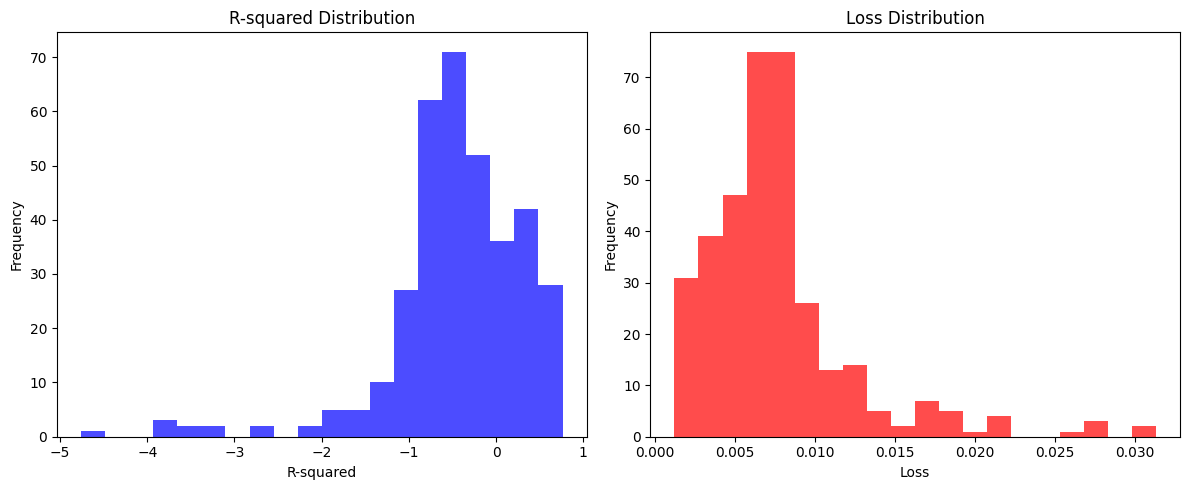

In [61]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(r2_list, bins=20, color='blue', alpha=0.7)
plt.title('R-squared Distribution')
plt.xlabel('R-squared')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(loss_list, bins=20, color='red', alpha=0.7)
plt.title('Loss Distribution')
plt.xlabel('Loss')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [64]:
dist_id_performance = {}
for i, dist_id in enumerate(unique_dist_ids):
    if dist_id not in dist_id_performance:
        dist_id_performance[dist_id] = []
    dist_id_performance[dist_id].append(r2_list[i])

# Print R-squared by dist_id
for dist_id, performances in dist_id_performance.items():
    print(f"Dist_id {dist_id} - Average R-squared: {np.mean(performances)}")

Dist_id 15.0 - Average R-squared: -0.387775580429087
Dist_id 36.0 - Average R-squared: 0.3572751197639863
Dist_id 20.0 - Average R-squared: 0.25094880863536495
Dist_id 35.0 - Average R-squared: -0.9973938716421058
Dist_id 34.0 - Average R-squared: 0.02784247814191987
Dist_id 1.0 - Average R-squared: 0.4617916745734172
Dist_id 3.0 - Average R-squared: 0.5422930531525085
Dist_id 19.0 - Average R-squared: -0.020288445243742403
Dist_id 13.0 - Average R-squared: 0.34677957609563603
Dist_id 17.0 - Average R-squared: 0.16635451811055102
Dist_id 21.0 - Average R-squared: -0.19251119180921084
Dist_id 2.0 - Average R-squared: -1.6445410039236465
Dist_id 18.0 - Average R-squared: -1.7338540942640708
Dist_id 29.0 - Average R-squared: -0.7918791671089533
Dist_id 6.0 - Average R-squared: -0.8330447709004092
Dist_id 16.0 - Average R-squared: -0.5470545616749853
Dist_id 11.0 - Average R-squared: -0.20096454585103052
Dist_id 5.0 - Average R-squared: -0.651488395248895
Dist_id 8.0 - Average R-squared: 0

In [22]:
# reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
# reserve_data

,source_dataset,island,dist_id,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,...,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,imp_c_scaled
0,FIA,Kauai,NaN,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,...,0.0,0.919650,0.946761,0.947442,0.833201,0.510523,0.000000,0.000000,0.000000,0.064231
100,FIA,Oahu,NaN,FIA_1433,FIA101,0,20,20,21.475448,-157.984458,...,0.0,0.900208,0.934330,0.924736,0.816007,0.514500,0.103332,0.157340,0.465517,0.064954
105,FIA,Oahu,NaN,FIA_1454,FIA106,0,20,20,21.419936,-157.906723,...,0.0,0.912301,0.935689,0.926505,0.833685,0.544245,0.042064,0.087616,0.655172,0.143556
10,FIA,Kauai,NaN,FIA_1077,FIA11,0,20,20,22.152306,-159.380618,...,0.0,0.879813,0.922948,0.922039,0.763581,0.495979,0.000000,0.000000,0.000000,0.099888
110,FIA,Oahu,NaN,FIA_1457,FIA111,0,20,20,21.404189,-157.854121,...,0.0,0.876864,0.910243,0.898774,0.769978,0.544770,0.021344,0.048273,0.086207,0.039570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,SH,Kauai,NaN,SH94-01,SH95,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000344,0.000000,0.017241,0.113633
5998,SH,Kauai,NaN,SH94-01,SH96,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000000,0.000000,0.000000,0.076609
5999,SH,Kauai,NaN,SH97-01,SH97,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000000,0.000000,0.000000,0.107264
6000,SH,Kauai,NaN,SH97-01,SH98,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.004729,0.013823,0.034483,0.025221


In [23]:
# reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
# reserve_data

,source_dataset,island,dist_id,soil_column_id,unique_id,depth_top,depth_bottom,depth_adj_bottom,latitude,longitude,...,swe,tmmn,tmmx,vap,vpd,vs,agbd_m,agbd_sd,agbd_n,imp_c_scaled
0,FIA,Kauai,NaN,FIA_1060,FIA1,0,20,20,22.185643,-159.350787,...,0.0,0.919650,0.946761,0.947442,0.833201,0.510523,0.007853,0.029866,0.120690,0.064231
100,FIA,Oahu,NaN,FIA_1433,FIA101,0,20,20,21.475448,-157.984458,...,0.0,0.900208,0.934330,0.924736,0.816007,0.514500,0.045713,0.057406,0.431034,0.064954
105,FIA,Oahu,NaN,FIA_1454,FIA106,0,20,20,21.419936,-157.906723,...,0.0,0.871936,0.909543,0.898124,0.762932,0.542160,0.029649,0.052557,0.258621,0.143556
10,FIA,Kauai,NaN,FIA_1077,FIA11,0,20,20,22.152306,-159.380618,...,0.0,0.846966,0.903061,0.902595,0.706792,0.491468,0.014825,0.042467,0.034483,0.099888
110,FIA,Oahu,NaN,FIA_1457,FIA111,0,20,20,21.404189,-157.854121,...,0.0,0.876864,0.910243,0.898774,0.769978,0.544770,0.035975,0.087150,0.103448,0.039570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5997,SH,Kauai,NaN,SH94-01,SH95,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.008747,0.024768,0.137931,0.113633
5998,SH,Kauai,NaN,SH94-01,SH96,0,15,20,21.967096,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.002663,0.008040,0.103448,0.076609
5999,SH,Kauai,NaN,SH97-01,SH97,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.002632,0.007358,0.103448,0.107264
6000,SH,Kauai,NaN,SH97-01,SH98,0,15,20,21.9670959,-159.692819,...,0.0,0.902048,0.954855,0.950564,0.826877,0.519562,0.000429,0.000000,0.017241,0.025221


In [24]:
# reserve_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
# r2_list = []
# loss_list = []
# prediction_list = []
# matched_data_list = []
# model_list = []
# for i in range(10):
#   matched_data = numeric_df[numeric_df['dist_id']!=xval_id].groupby('unique_id').sample(n=1)
#   matched_data = matched_data.reset_index(drop=True)
#   model, test_loss, r_squared, predictions, y_test = train_model_a(matched_data)
#   predictions = predict_on_reserve(reserve_data, model, min_c, max_c)
#   matched_data_list.append(matched_data)
#   prediction_list.append(predictions)
#   model_list.append(model)

Epoch 1/100
14/14 [==============================] - 5s 21ms/step - loss: 1.9651 - val_loss: 0.0427
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 1.4757 - val_loss: 0.0199
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 1.1460 - val_loss: 0.0190
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 0.8557 - val_loss: 0.0212
Epoch 5/100
14/14 [==============================] - 0s 7ms/step - loss: 0.6415 - val_loss: 0.0217
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 0.5823 - val_loss: 0.0211
Epoch 7/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4992 - val_loss: 0.0194
Epoch 8/100
14/14 [==============================] - 0s 7ms/step - loss: 0.4427 - val_loss: 0.0211
Epoch 9/100
14/14 [==============================] - 0s 8ms/step - loss: 0.3714 - val_loss: 0.0215
Epoch 10/100
14/14 [==============================] - 0s 7ms/step - loss: 0.3661 - val_loss: 0.0190
Epoch 11

In [25]:

# X = preprocess_data[keep_cols]

# [model.predict(reserve_data[keep_cols]) for model in model_list]

In [26]:
[np.all(prediction['predictions'] ==prediction_list[0]['predictions']) for prediction in prediction_list]

[True, False, False, False, False, False, False, False, False, False]

In [27]:
# prediction_list[0]

In [28]:
combined_array = np.array([predictions['predictions'].values for predictions in prediction_list])

In [29]:
combined_array[combined_array < 0 ] = 0

In [30]:
# combined_array[0]

In [31]:
arr_min = np.min(combined_array.flatten())
arr_max = np.max(combined_array.flatten())

In [32]:
arr_max

0.48603582

In [33]:
dist_array = [np.sort(np.array([i[j] for  i in combined_array])) for j in range(combined_array.shape[1])]
norm_dist_array =  [np.sort((np.array([i[j] for  i in combined_array]) - arr_min) / (arr_max-arr_min)) for j in range(combined_array.shape[1])]

In [34]:
# norm_dist_array

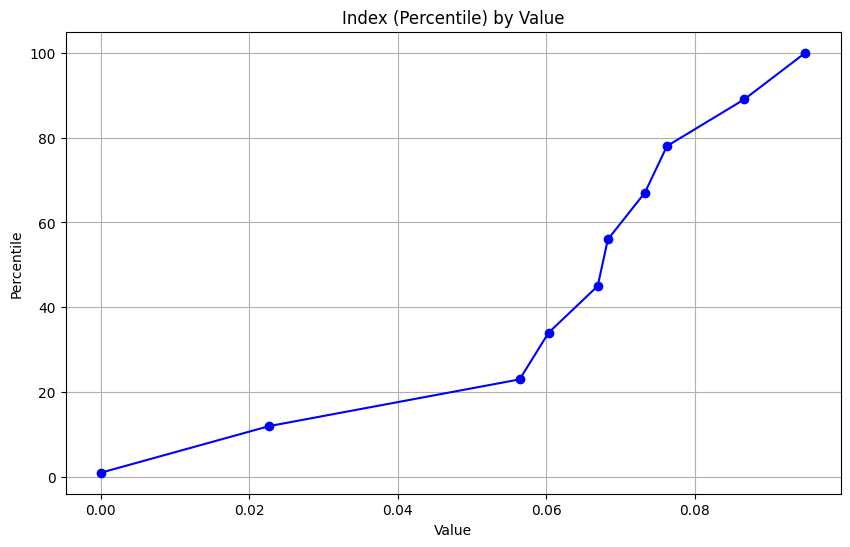

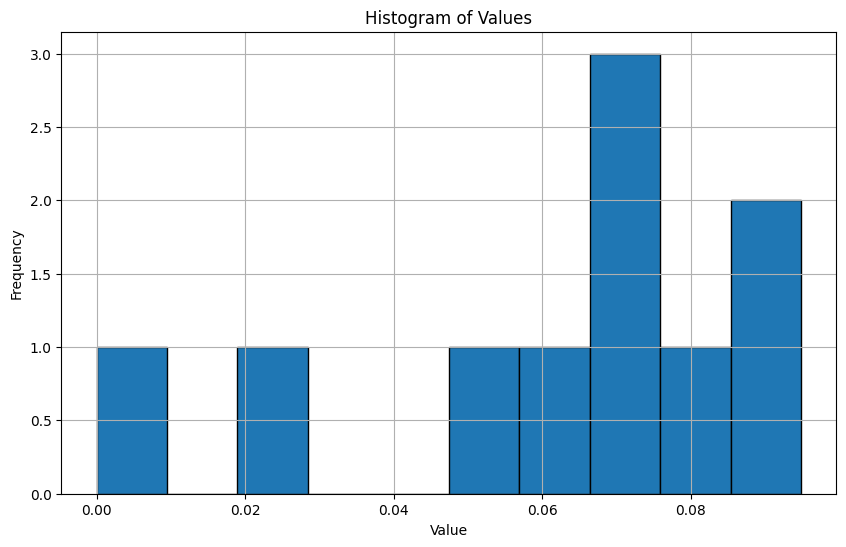

In [35]:
array = norm_dist_array[1]
# Generating y values as indices (percentiles in this context)
y_values = np.linspace(1, 100, len(array))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(array, y_values, marker='o', linestyle='-', color='b')
plt.title('Index (Percentile) by Value')
plt.xlabel('Value')
plt.ylabel('Percentile')
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
plt.hist(array, bins=len(array), edgecolor='black')
plt.title('Histogram of Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [36]:
keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
            'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
            'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
            'agbd_m', 'agbd_sd', 'agbd_n']

scaled_numeric_df = prediction_list[0][keep_cols]
# numeric_cols = predictions.iloc[:,keep_cols]

scaled_numeric_df['norm_dist_array'] = norm_dist_array

# id_fields = predictions[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

# numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)


<ipython-input-36-eadb985067ec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = norm_dist_array


In [37]:
numeric_df.columns

Index(['source_dataset', 'island', 'dist_id', 'soil_column_id', 'unique_id',
       'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude',
       'longitude', 'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
       'shrub_and_scrub', 'built', 'bare', 'snow_and_ice', 'max', 'elevation',
       'landform', 'SRTM_mTPI', 'aet', 'def', 'pdsi', 'pet', 'pr', 'ro',
       'soil', 'srad', 'swe', 'tmmn', 'tmmx', 'vap', 'vpd', 'vs', 'agbd_m',
       'agbd_sd', 'agbd_n', 'imp_c_scaled'],
      dtype='object')

In [38]:
# Model Definition
def build_model(input_shape,output_shape):
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_shape),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(512, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        LeakyReLU(alpha=0.2),
        Dropout(0.3),
        Dense(output_shape, activation='linear')
    ])
    return model


In [39]:
scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()

<ipython-input-39-4a7713e6d101>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df['norm_dist_array'] = scaled_numeric_df['norm_dist_array'].to_list()


In [40]:
scaled_numeric_df.dropna(inplace=True)

<ipython-input-40-8f639aa31ceb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_numeric_df.dropna(inplace=True)


In [41]:
norm_dist_array = np.array([i for i in scaled_numeric_df['norm_dist_array']])

In [42]:

X = scaled_numeric_df.iloc[:, :-1]
y = scaled_numeric_df.iloc[:, -1]

x = np.array(X)
y = np.array(norm_dist_array)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [43]:
# print(X_train.shape[1])
model = build_model(X_train.shape[1],output_shape=10)

In [44]:
y_train.shape

(2170, 10)

In [45]:
# model = build_model((X_train.shape[1]))
# model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error',metrics = ['mae'])
# model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics = ['mae'])
model.fit(X_train, y_train, validation_split=0.2, epochs=600, batch_size=128, verbose=1)

test_loss = model.evaluate(X_test, y_test)

# Predictions and Evaluation
predictions = model.predict(X_test)

Epoch 1/600
14/14 [==============================] - 2s 20ms/step - loss: 1.9869 - mae: 1.0514 - val_loss: 0.0528 - val_mae: 0.1645
Epoch 2/600
14/14 [==============================] - 0s 7ms/step - loss: 1.6307 - mae: 0.9574 - val_loss: 0.0560 - val_mae: 0.1719
Epoch 3/600
14/14 [==============================] - 0s 7ms/step - loss: 1.5115 - mae: 0.9206 - val_loss: 0.0586 - val_mae: 0.1791
Epoch 4/600
14/14 [==============================] - 0s 7ms/step - loss: 1.4028 - mae: 0.8832 - val_loss: 0.0596 - val_mae: 0.1816
Epoch 5/600
14/14 [==============================] - 0s 7ms/step - loss: 1.3437 - mae: 0.8664 - val_loss: 0.0603 - val_mae: 0.1832
Epoch 6/600
14/14 [==============================] - 0s 7ms/step - loss: 1.2800 - mae: 0.8411 - val_loss: 0.0614 - val_mae: 0.1859
Epoch 7/600
14/14 [==============================] - 0s 7ms/step - loss: 1.1971 - mae: 0.8176 - val_loss: 0.0619 - val_mae: 0.1873
Epoch 8/600
14/14 [==============================] - 0s 7ms/step - loss: 1.1436 - 

In [46]:
i = 4
for i in range(5):
  print(predictions[i])
  print(y_test[i])

[0.08801597 0.10159403 0.10897776 0.11692027 0.12508047 0.13166237
 0.13666101 0.14526252 0.15155786 0.16709872]
[0.11421205 0.11733991 0.12181396 0.12852503 0.13232046 0.13491733
 0.1645327  0.16583636 0.16977805 0.17887105]
[-0.02547871 -0.02070893 -0.01776171 -0.01471613 -0.00654102  0.0035128
  0.01237021  0.02162656  0.03223492  0.05283076]
[0.         0.         0.         0.         0.00271856 0.00641652
 0.01568    0.05428079 0.09106989 0.1104058 ]
[0.21729702 0.2503034  0.27858377 0.2979681  0.3170495  0.3309493
 0.3644697  0.40907037 0.44352219 0.5122337 ]
[0.22312596 0.23210113 0.25122726 0.27785528 0.28902128 0.35091636
 0.35762677 0.3704645  0.4911274  0.5572491 ]
[-0.00233073  0.0034712   0.01783715  0.02386891  0.03104104  0.04387031
  0.05845328  0.06806409  0.06927784  0.10355996]
[0.         0.00830999 0.02435155 0.03177946 0.03977802 0.05339408
 0.0709334  0.08209243 0.08806037 0.12477043]
[0.02229191 0.03312197 0.03875092 0.05505775 0.06442235 0.07330818
 0.08112668

In [47]:
xval_data = numeric_df[numeric_df['dist_id']==xval_id]

In [48]:
# Select numeric columns and preprocess
keep_cols = ['water', 'trees','grass', 'flooded_vegetation', 'crops', 'shrub_and_scrub', 'built',
              'bare', 'snow_and_ice', 'max', 'elevation', 'landform', 'SRTM_mTPI','aet', 'def',
              'pdsi', 'pet', 'pr', 'ro', 'soil', 'srad', 'swe', 'tmmn','tmmx', 'vap', 'vpd', 'vs',
              'agbd_m', 'agbd_sd', 'agbd_n']
numeric_cols = drivers_gpd[keep_cols]
numeric_cols.replace('', np.nan, inplace=True)
numeric_cols = numeric_cols.astype(float)
numeric_cols.fillna(0, inplace=True)

# # Scale numeric columns
# scaler = MinMaxScaler()
# scaler.fit(numeric_cols)
scaled_numeric_cols = scaler.transform(numeric_cols)
scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

<ipython-input-48-22ddb3545118>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_cols.replace('', np.nan, inplace=True)


In [49]:
drivers_gpd['dist_class'] = predicted_predicted_labels

NameError: name 'predicted_predicted_labels' is not defined

In [ ]:
drivers_gpd['median'] = [prediction[5]*max_c+min_c for prediction in fishnet_predictions]

In [ ]:
drivers_gpd.to_file('/content/drive/MyDrive/hawaii_soils/dist_class_drivers.gpkg')

In [ ]:
fishnet_predictions = model.predict(scaled_numeric_df)

In [ ]:
fishnet_predictions

In [ ]:
xval_predictions = model.predict(xval_data[keep_cols])

In [ ]:
xval_data

In [ ]:
xval_norm_predictions = [prediction*max_c+min_c for prediction in xval_predictions]

In [ ]:
xval_quantiles = np.quantile((xval_data['imp_c_scaled']*max_c+min_c).unique(), np.linspace(0, 1,10))

In [ ]:
[np.mean(np.sort(prediction) - np.sort(xval_quantiles)) for prediction in xval_norm_predictions]

In [ ]:
xval_data['mean_resid']= [np.mean(np.sort(prediction) - np.sort(xval_quantiles)) for prediction in xval_norm_predictions]

In [ ]:
xval_data['geometry'] = [Point(xy) for xy in zip(xval_data['longitude'], xval_data['latitude'])]

# Convert the DataFrame to a GeoDataFrame
gdf = gpd.GeoDataFrame(xval_data, geometry='geometry')

# Set the coordinate reference system (CRS) for the GeoDataFrame
gdf.set_crs(epsg=4326, inplace=True)

gdf.to_file('test.gpkg')

In [104]:
def normal_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return np.random.normal(variable_mean, variable_sd, n)

def uniform_generator(n, min_val, max_val, min_variation, max_variation):
    variable_min = min_val + np.random.uniform(-min_variation * 2, min_variation * 2)
    variable_max = max_val + np.random.uniform(-max_variation * 2, max_variation * 2)
    return np.random.uniform(variable_min, variable_max, n)

def right_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return np.random.lognormal(variable_mean, variable_sd, n)

def left_tailed_generator(n, mean, sd, mean_variation, sd_variation):
    variable_mean = mean + np.random.normal(0, mean_variation * 2)
    variable_sd = sd + abs(np.random.normal(0, sd_variation * 2))
    return -np.random.lognormal(variable_mean, variable_sd, n)

def multimodal_generator(ns, means, sds, mean_variation, sd_variation):
    samples_list = []
    for i in range(len(means)):
        variable_mean = means[i] + np.random.normal(0, mean_variation * 2)
        variable_sd = sds[i] + abs(np.random.normal(0, sd_variation * 2))
        samples_list.append(np.random.normal(variable_mean, variable_sd, ns[i]))
    return np.concatenate(samples_list)

In [105]:
def rescale_to_minus_one_one(values):
    min_value = np.min(values)
    max_value = np.max(values)
    scaled_values = 2 * ((values - min_value) / (max_value - min_value)) - 1
    return scaled_values

In [106]:
def generate_samples(n, q, generator_func, *args):
    samples = generator_func(n, *args)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)

def generate_normal_samples(n=10000, q=10, mean_value=0, sd_value=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, normal_generator, mean_value, sd_value, mean_variation, sd_variation)

def generate_uniform_samples(n=10000, q=10, min_value=-1, max_value=1, min_variation=0.5, max_variation=0.5):
    return generate_samples(n, q, uniform_generator, min_value, max_value, min_variation, max_variation)

def generate_right_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, right_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_left_tailed_samples(n=10000, q=10, mean=0, sd=1, mean_variation=0.5, sd_variation=0.5):
    return generate_samples(n, q, left_tailed_generator, mean, sd, mean_variation, sd_variation)

def generate_multimodal_samples(ns=[1000, 50], q=10, means=[1, -1], sds=[1, 0.5], mean_variation=0.5, sd_variation=0.5):
    samples = multimodal_generator(ns, means, sds, mean_variation, sd_variation)
    samples_q = np.quantile(samples, np.linspace(0, 1, q))
    return rescale_to_minus_one_one(samples_q)


In [107]:
def generate_training_data(n_samples=10000):
    data_list = {}

    # Generate samples for each distribution type
    data_list['normal'] = [generate_normal_samples() for _ in range(n_samples)]
    data_list['bimodal'] = [generate_multimodal_samples() for _ in range(n_samples)]
    data_list['uniform'] = [generate_uniform_samples() for _ in range(n_samples)]
    data_list['right_tailed'] = [generate_right_tailed_samples() for _ in range(n_samples)]
    data_list['left_tailed'] = [generate_left_tailed_samples() for _ in range(n_samples)]

    # Combine all data into a single DataFrame
    combined_data = pd.DataFrame()
    for name, samples_list in data_list.items():
        df = pd.DataFrame(samples_list)
        df['label'] = name
        combined_data = pd.concat([combined_data, df], ignore_index=True)

    # Assign column names
    combined_data.columns = [f'V{i+1}' for i in range(combined_data.shape[1] - 1)] + ['label']

    return combined_data

In [108]:
training_data = generate_training_data()

In [109]:
# Separate features and labels
X = training_data.drop(columns=['label'])
y = training_data['label']

# Encode labels as integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=500, max_leaf_nodes=50, min_samples_leaf=2, random_state=123)

# Train the model
rf_model.fit(X, y_encoded)

# Print the trained model
print(rf_model)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=2, n_estimators=500,
                       random_state=123)


In [110]:
reference_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  y_test]

In [111]:
some_new_data = training_data = generate_training_data()

In [112]:
prediction_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  predictions]

In [113]:
# xval_data

In [114]:
real_quantiles.columns = [f'V{i+1}' for i in range(real_quantiles.shape[1])]

NameError: name 'real_quantiles' is not defined

In [ ]:
real_data_rf_ready_predictions = [rescale_to_minus_one_one(sorted(prediction)) for prediction in  fishnet_predictions ]

In [ ]:
# Assuming real_data_rf_ready_predictions is your list of predictions
# real_data_rf_ready_predictions = [prediction for prediction in real_data_rf_ready_predictions if not np.any(np.isnan(prediction))]


In [ ]:
# real_data_rf_ready_predictions

In [ ]:
# real_quantiles = quantiles.unstack().reset_index().iloc[:,1:]

In [ ]:
# real_data_rf_ready_predictions

In [ ]:
# Assuming `new_data` is your new dataset without the 'label' column

# Use the trained model to make predictions
predicted_labels_encoded = rf_model.predict(real_data_rf_ready_predictions)

# Decode the encoded labels back to original labels
predicted_predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

# Output the predictions
print(predicted_predicted_labels)


In [ ]:
cm = confusion_matrix(predicted_predicted_labels, reference_predicted_labels)
cm

In [ ]:

# Assuming 'my_array' is your numpy array
unique_values, counts = np.unique(predicted_predicted_labels, return_counts=True)

# Create a DataFrame to display the counts in a table format
counts_table = pd.DataFrame({
    'Unique Value': unique_values,
    'Count': counts
})

# Display the table
print(counts_table)


In [ ]:
unique_values, counts = np.unique(predicted_labels, return_counts=True)

# Create a DataFrame to display the counts in a table format
counts_table = pd.DataFrame({
    'Unique Value': unique_values,
    'Count': counts
})

# Display the table
print(counts_table)


In [ ]:
# matches_within_distance[matches_within_distance['dist_id']!=xval_id].groupby('unique_id').sample(n=1)

In [ ]:
xval_data = matches_within_distance[matches_within_distance['dist_id']==xval_id]

In [ ]:
quantiles = xval_data[xval_data['depth_adj_bottom'] =="20" ].groupby('unique_id').sample(n=1)['imp_c'].astype(float).quantile(np.linspace(0, 1,10))

In [ ]:
keep_cols = [21,22,23,24,25,26,27,28, 29, 31,32, 33,34,36,36,37,38,39,40,41,42,43,44,45,46,47, 48]

numeric_cols = xval_data.iloc[:,keep_cols]

# scaler = MinMaxScaler()

scaler.fit(numeric_cols)

scaled_numeric_cols = scaler.transform(numeric_cols)

scaled_numeric_df = pd.DataFrame(scaled_numeric_cols, columns=numeric_cols.columns, index=numeric_cols.index)

# scaled_numeric_df['norm_dist_array'] = norm_dist_array

id_fields = xval_data[['source_dataset', 'island', 'soil_column_id', 'unique_id', 'depth_top', 'depth_bottom', 'depth_adj_bottom', 'latitude', 'longitude']]

numeric_df = pd.concat([id_fields, scaled_numeric_df], axis=1)

In [ ]:
X = scaled_numeric_df.iloc[:, :-1]


In [ ]:
predictions = model.predict(scaled_numeric_df)

In [ ]:
predictions

In [ ]:
dummy_array = np.full((len(predictions), 28), fill_value=0.5)  # Example for reverse scaling
dummy_array[:, -1] = predictions
inversed_predictions = scaler.inverse_transform(dummy_array)[:, -1]
dummy_array[:, -1] = y_test
inversed_truth = scaler.inverse_transform(dummy_array)[:, -1]